<a href="https://colab.research.google.com/github/divya28jain/Text-Classification-Jax-transformer/blob/main/Text_Classification_Jax_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
 !pip install -U jax flax optax
 !pip install -U grain tqdm requests matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 53.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 MB 9.0 MB/s eta 0:00:00
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.5.1
    Uninstalling jaxlib-0.5.1:
      Successfully uninstalled jaxlib-0.5.1
  Attempting uninstall: jax
    Found existing installation: jax 0.5.2
    Uninstalling jax-0.5.2:
      Successfully uninstalled jax-0.5.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 433.5/433.5 kB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 73.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.2/55.2 kB 4.6 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.10.0
    Uninstalling matplotlib-3.10.0:
      Successfully uninstalled matplotlib-3.10.0


In [2]:
import io
import json
import textwrap
import typing

import jax
import jax.numpy as jnp
from flax import nnx
import optax
import grain.python as grain
import tqdm
import matplotlib.pyplot as plt
import numpy as np
import requests

/usr/local/lib/python3.11/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.5.1 is installed, but it is not compatible with the installed jaxlib version 0.5.3, so it will not be used.
  warnings.warn(


In [5]:
def prepare_imdb_dataset(num_words: int, index_from: int, oov_char: int = 2) -> tuple:
    response = requests.get("https://storage.googleapis.com/tensorflow/tf-keras-datasets/imdb.npz")
    response.raise_for_status()
    with np.load(io.BytesIO(response.content), allow_pickle=True) as f:
        x_train, y_train = f["x_train"], f["y_train"]
        x_test, y_test = f["x_test"], f["y_test"]

    rng = np.random.RandomState(113)
    indices = np.arange(len(x_train))
    rng.shuffle(indices)
    x_train = x_train[indices]
    y_train = y_train[indices]

    indices = np.arange(len(x_test))
    rng.shuffle(indices)
    x_test = x_test[indices]
    y_test = y_test[indices]

    x_train = [[w + index_from for w in x] for x in x_train]
    x_test = [[w + index_from for w in x] for x in x_test]

    xs = x_train + x_test
    labels = np.concatenate([y_train, y_test])
    xs = [
        [w if w < num_words else oov_char for w in x] for x in xs
    ]

    idx = len(x_train)
    x_train, y_train = np.array(xs[:idx], dtype="object"), labels[:idx]
    x_test, y_test = np.array(xs[idx:], dtype="object"), labels[idx:]

    return (x_train, y_train), (x_test, y_test)


def pad_sequences(arrs: typing.Iterable, max_len: int) -> np.ndarray:
    # Ensure that each sample is the same length
    result = []
    for arr in arrs:
        arr_len = len(arr)
        if arr_len < max_len:
            padded_arr = np.pad(arr, (max_len - arr_len, 0), 'constant', constant_values=0)
        else:
            padded_arr = np.array(arr[arr_len - max_len:])
        result.append(padded_arr)

    return np.asarray(result)

In [6]:
index_from = 3
vocab_size = 20000
maxlen = 200
(x_train, y_train), (x_test, y_test) = prepare_imdb_dataset(num_words=vocab_size, index_from=index_from)
print(len(x_train), "Training sequences")
print(len(x_test), "Validation sequences")
x_train = pad_sequences(x_train, max_len=maxlen)
x_test = pad_sequences(x_test, max_len=maxlen)

25000 Training sequences
25000 Validation sequences


In [7]:
class DataSource(grain.RandomAccessDataSource):
    def __init__(self, x, y):
        self._x = x
        self._y = y

    def __getitem__(self, idx):
        return {"encoded_indices": self._x[idx], "label": self._y[idx]}

    def __len__(self):
        return len(self._x)

In [8]:
train_source = DataSource(x_train, y_train)
test_source = DataSource(x_test, y_test)

In [9]:
seed = 12
train_batch_size = 128
test_batch_size = 2 * train_batch_size

train_sampler = grain.IndexSampler(
    len(train_source),
    shuffle=True,
    seed=seed,
    shard_options=grain.NoSharding(),  # No sharding since this is a single-device setup
    num_epochs=1,                      # Iterate over the dataset for one epoch
)

test_sampler = grain.IndexSampler(
    len(test_source),
    shuffle=False,
    seed=seed,
    shard_options=grain.NoSharding(),  # No sharding since this is a single-device setup
    num_epochs=1,                      # Iterate over the dataset for one epoch
)


train_loader = grain.DataLoader(
    data_source=train_source,
    sampler=train_sampler,  # Sampler to determine how to access the data
    worker_count=4,         # Number of child processes launched to parallelize the transformations among
    worker_buffer_size=2,   # Count of output batches to produce in advance per worker
    operations=[
        grain.Batch(train_batch_size, drop_remainder=True),
    ]
)

test_loader = grain.DataLoader(
    data_source=test_source,
    sampler=test_sampler,  # Sampler to determine how to access the data
    worker_count=4,        # Number of child processes launched to parallelize the transformations among
    worker_buffer_size=2,  # Count of output batches to produce in advance per worker
    operations=[
        grain.Batch(test_batch_size),
    ]
)

In [10]:
class TransformerBlock(nnx.Module):
    def __init__(self, embed_dim: int, num_heads: int, ff_dim: int, rngs: nnx.Rngs, rate: float = 0.1):
        self.attention = nnx.MultiHeadAttention(
            num_heads=num_heads, in_features=embed_dim, qkv_features=embed_dim, decode=False, rngs=rngs
        )

        self.dense_1 = nnx.Linear(in_features=embed_dim, out_features=ff_dim, rngs=rngs)
        self.dense_2 = nnx.Linear(in_features=ff_dim, out_features=ff_dim, rngs=rngs)

        self.layer_norm_1 = nnx.LayerNorm(num_features=embed_dim, epsilon=1e-6, rngs=rngs)
        self.layer_norm_2 = nnx.LayerNorm(num_features=ff_dim, epsilon=1e-6, rngs=rngs)

        self.dropout_1 = nnx.Dropout(rate, rngs=rngs)
        self.dropout_2 = nnx.Dropout(rate, rngs=rngs)

    def __call__(self, inputs: jax.Array):
        x = self.attention(inputs, inputs)
        x = self.dropout_1(x)
        x_norm_1 = self.layer_norm_1(inputs + x)
        x = self.dense_1(x_norm_1)
        x = jax.nn.relu(x)
        x = self.dense_2(x)
        x = self.dropout_2(x)
        x = self.layer_norm_2(x_norm_1 + x)
        return x

In [11]:
class TokenAndPositionEmbedding(nnx.Module):
    def __init__(self, max_length: int, vocab_size: int, embed_dim: int, rngs: nnx.Rngs):
        self.token_emb = nnx.Embed(num_embeddings=vocab_size, features=embed_dim, rngs=rngs)
        self.pos_emb = nnx.Embed(num_embeddings=max_length, features=embed_dim, rngs=rngs)

    def __call__(self, x: jax.Array):
        maxlen = jnp.shape(x)[-1]
        positions = jnp.arange(start=0, stop=maxlen, step=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [12]:
embed_dim = 32
num_heads = 2
ff_dim = 32

class MyModel(nnx.Module):
    def __init__(self, rngs: nnx.Rngs):
        self.embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim, rngs=rngs)
        self.transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim, rngs=rngs)
        self.dropout1 = nnx.Dropout(0.1, rngs=rngs)
        self.dense1 = nnx.Linear(in_features=embed_dim, out_features=20, rngs=rngs)
        self.dropout2 = nnx.Dropout(0.1, rngs=rngs)
        self.dense2 = nnx.Linear(in_features=20, out_features=2, rngs=rngs)

    def __call__(self, x: jax.Array):
        x = self.embedding_layer(x)
        x = self.transformer_block(x)
        x = jnp.mean(x, axis=(1,))
        x = self.dropout1(x)
        x = self.dense1(x)
        x = jax.nn.relu(x)
        x = self.dropout2(x)
        x = self.dense2(x)
        x = jax.nn.softmax(x)
        return x

In [13]:
model = MyModel(rngs=nnx.Rngs(0))
nnx.display(model)

In [14]:
num_epochs = 10
learning_rate = 0.0001
momentum = 0.9

optimizer = nnx.Optimizer(model, optax.adam(learning_rate, momentum))

In [15]:
def compute_losses_and_logits(model: nnx.Module, batch_tokens: jax.Array, labels: jax.Array):
    logits = model(batch_tokens)

    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=labels
    ).mean()
    return loss, logits

In [16]:
@nnx.jit
def train_step(
    model: nnx.Module, optimizer: nnx.Optimizer, batch: dict[str, jax.Array]
):
    batch_tokens = jnp.array(batch["encoded_indices"])
    labels = jnp.array(batch["label"], dtype=jnp.int32)

    grad_fn = nnx.value_and_grad(compute_losses_and_logits, has_aux=True)
    (loss, logits), grads = grad_fn(model, batch_tokens, labels)

    optimizer.update(grads)  # In-place updates.

    return loss

@nnx.jit
def eval_step(
    model: nnx.Module, batch: dict[str, jax.Array], eval_metrics: nnx.MultiMetric
):
    batch_tokens = jnp.array(batch["encoded_indices"])
    labels = jnp.array(batch["label"], dtype=jnp.int32)
    loss, logits = compute_losses_and_logits(model, batch_tokens, labels)

    eval_metrics.update(
        loss=loss,
        logits=logits,
        labels=labels,
    )

In [17]:
eval_metrics = nnx.MultiMetric(
    loss=nnx.metrics.Average('loss'),
    accuracy=nnx.metrics.Accuracy(),
)

train_metrics_history = {
    "train_loss": [],
}

eval_metrics_history = {
    "test_loss": [],
    "test_accuracy": [],
}

In [19]:
bar_format = "{desc}[{n_fmt}/{total_fmt}]{postfix} [{elapsed}<{remaining}]"
train_total_steps = len(x_train) // train_batch_size

def train_one_epoch(epoch):
    model.train()
    with tqdm.tqdm(
        desc=f"[train] epoch: {epoch}/{num_epochs}, ",
        total=train_total_steps,
        bar_format=bar_format,
        leave=True,
    ) as pbar:
        for batch in train_loader:
            loss = train_step(model, optimizer, batch)
            train_metrics_history["train_loss"].append(loss.item())
            pbar.set_postfix({"loss": loss.item()})
            pbar.update(1)


def evaluate_model(epoch):
    model.eval()

    eval_metrics.reset()
    for test_batch in test_loader:
        eval_step(model, test_batch, eval_metrics)

    for metric, value in eval_metrics.compute().items():
        eval_metrics_history[f'test_{metric}'].append(value)

    print(f"[test] epoch: {epoch + 1}/{num_epochs}")
    print(f"- total loss: {eval_metrics_history['test_loss'][-1]:0.4f}")
    print(f"- Accuracy: {eval_metrics_history['test_accuracy'][-1]:0.4f}")

In [20]:
%%time
for epoch in range(num_epochs):
    train_one_epoch(epoch)
    evaluate_model(epoch)

[train] epoch: 0/10, [192/195], loss=0.689 [00:16<00:00]


[test] epoch: 1/10
- total loss: 0.6906
- Accuracy: 0.5563


[train] epoch: 1/10, [192/195], loss=0.683 [00:05<00:00]


[test] epoch: 2/10
- total loss: 0.6832
- Accuracy: 0.6271


[train] epoch: 2/10, [192/195], loss=0.647 [00:05<00:00]


[test] epoch: 3/10
- total loss: 0.6576
- Accuracy: 0.6930


[train] epoch: 3/10, [192/195], loss=0.557 [00:05<00:00]


[test] epoch: 4/10
- total loss: 0.5779
- Accuracy: 0.7675


[train] epoch: 4/10, [192/195], loss=0.471 [00:06<00:00]


[test] epoch: 5/10
- total loss: 0.5100
- Accuracy: 0.8095


[train] epoch: 5/10, [192/195], loss=0.435 [00:06<00:00]


[test] epoch: 6/10
- total loss: 0.4821
- Accuracy: 0.8283


[train] epoch: 6/10, [192/195], loss=0.416 [00:05<00:00]


[test] epoch: 7/10
- total loss: 0.4708
- Accuracy: 0.8365


[train] epoch: 7/10, [192/195], loss=0.404 [00:05<00:00]


[test] epoch: 8/10
- total loss: 0.4635
- Accuracy: 0.8417


[train] epoch: 8/10, [192/195], loss=0.389 [00:05<00:00]


[test] epoch: 9/10
- total loss: 0.4583
- Accuracy: 0.8460


[train] epoch: 9/10, [192/195], loss=0.372 [00:06<00:00]


[test] epoch: 10/10
- total loss: 0.4537
- Accuracy: 0.8510
CPU times: user 29.3 s, sys: 5.65 s, total: 35 s
Wall time: 1min 53s


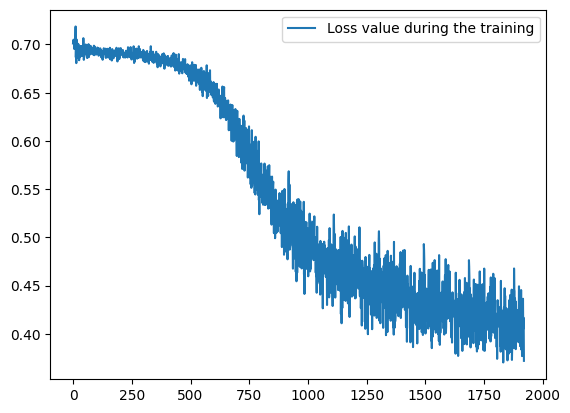

In [21]:
plt.plot(train_metrics_history["train_loss"], label="Loss value during the training")
plt.legend()

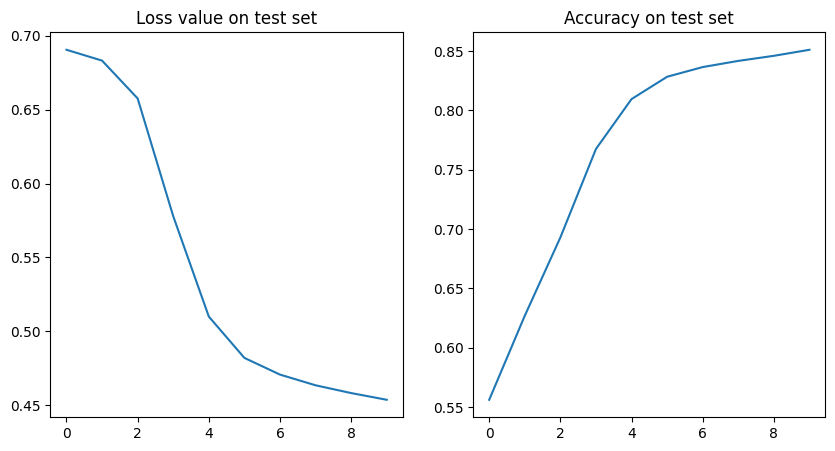

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].set_title("Loss value on test set")
axs[0].plot(eval_metrics_history["test_loss"])
axs[1].set_title("Accuracy on test set")
axs[1].plot(eval_metrics_history["test_accuracy"])

In [23]:
response = requests.get("https://storage.googleapis.com/tensorflow/tf-keras-datasets/imdb_word_index.json")
response.raise_for_status()
word_map = {v: k for k, v in json.loads(response.content).items()}

In [24]:
def _label_to_str(label: int) -> str:
    return "positive" if label else "negative"

def show_reviews(indices: list[int]) -> None:
    for idx in indices:
        x = x_test[idx][x_test[idx] != 0]
        y = y_test[idx]
        y_pred = model(x_test[idx][None, :]).argmax()
        review = ""
        for w_x in x:
            idx = w_x - index_from if w_x >= index_from else w_x
            review += f"{word_map[idx]} "

        print("Review:")
        for line in textwrap.wrap(review):
            print(line)
        print("Predicted sentiment: ", _label_to_str(y_pred))
        print("Actual sentiment: ", _label_to_str(y), "\n")

In [25]:
show_reviews([0, 500, 600, 1000, 1800, 2000])

Review:
please give this one a miss br br kristy swanson and the rest of the
cast rendered terrible performances the show is flat flat flat br br i
don't know how michael madison could have allowed this one on his
plate he almost seemed to know this wasn't going to work out and his
performance was quite lacklustre so all you madison fans give this a
miss
Predicted sentiment:  negative
Actual sentiment:  negative 

Review:
this is a funny movie the bob eddie show feel of it could lead to a
sequel but i doubt it will make enough money br br deniro proves he
can be a great straight man again with some hilarious and spontaneous
moments eddie was fun to watch working with people instead of cgi
animals and and rene russo well she's just fun to watch anyway and
she's played her part excellent br br some wild and unusual stunts
especially the garbage truck scene this was worth seeing in the
theater we needed a good laugh and got many from the movie and the
great out takes at the end do not lea